<a href="https://colab.research.google.com/github/susie682/Infosys722--Assignment-4-BDAS/blob/main/6_1_AlgoExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6.1 Exploratory Analysis of Data-Mining Algorithms (Chicago Crime 2017)

**Input**: `/content/drive/MyDrive/Infosys 722/tables/CrimeData2017_reduced_projected.csv`  
**Output figs**: `/content/drive/MyDrive/Infosys 722/figs/` (Figures 53–57)

The notebook performs forward-in-time evaluation aligned with project objectives:
- **Objective 1 (O1)**: next-month hotspot classification (top-10% per month).
- **Objective 2 (O2)**: next-month count regression vs. naïve baselines.

All comments are in English, and the code is defensive to accommodate slight column name variations from Section 4.2.


In [1]:
# ==== 0. Setup & paths ====
# Mount Google Drive when running in Colab
try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
except Exception:
    pass

import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import average_precision_score, precision_recall_curve, mean_absolute_error

FIG_DIR = "/content/drive/MyDrive/Infosys 722/figs"
TAB_DIR = "/content/drive/MyDrive/Infosys 722/tables"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)
CSV_IN = os.path.join(TAB_DIR, "CrimeData2017_reduced_projected.csv")
print("CSV_IN:", CSV_IN)

Mounted at /content/drive
CSV_IN: /content/drive/MyDrive/Infosys 722/tables/CrimeData2017_reduced_projected.csv


In [4]:
# ===== Load & normalize keys for CrimeData2017_reduced_projected.csv =====
import pandas as pd
import numpy as np

CSV_IN = "/content/drive/MyDrive/Infosys 722/tables/CrimeData2017_reduced_projected.csv"  # 你的表路径
df = pd.read_csv(CSV_IN)
print("Loaded:", df.shape)
print("Columns:", list(df.columns))

# 1) Ensure Month exists and is valid
if "Month" not in df.columns:
    raise ValueError("Expected 'Month' column in the reduced_projected CSV.")
df["Month"] = pd.to_numeric(df["Month"], errors="coerce").clip(1, 12).astype(int)

# 2) Ensure Year (this file is 2017-only)
if "Year" not in df.columns:
    df["Year"] = 2017
else:
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce").fillna(2017).astype(int)

# 3) Normalize District key
if "District" not in df.columns:
    # （本文件已有 District；此分支只是兜底）
    # 也可改成从包含 'district' 的列自动识别
    raise ValueError("Expected 'District' column in the reduced_projected CSV.")
df["District"] = pd.to_numeric(df["District"], errors="coerce").astype("Int64")
df["District"] = df["District"].fillna(method="ffill").fillna(method="bfill").astype(int)

# 4) Period key & ordering
df = df.sort_values(["Year", "Month", "District"]).reset_index(drop=True)
df["period_ym"] = df["Year"].astype(str) + "-" + df["Month"].astype(str).str.zfill(2)

print("First periods:", df["period_ym"].unique()[:6])
df.head(3)


Loaded: (267, 15)
Columns: ['District', 'Month', 'Total', 'District_Month_ArrestRate', 'District_Month_DomesticRate', 'NightShare_DistMonth', 'OutdoorShare_DistMonth', 'Roll3Mean_DistMonth', 'y_count_next', 'District_Month_ArrestRate_logit', 'District_Month_DomesticRate_logit', 'NightShare_DistMonth_logit', 'OutdoorShare_DistMonth_logit', 'Roll3Mean_DistMonth_log1p', 'y_count_next_log1p']
First periods: ['2017-01' '2017-02' '2017-03' '2017-04' '2017-05' '2017-06']


/tmp/ipython-input-3625208824.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["District"] = df["District"].fillna(method="ffill").fillna(method="bfill").astype(int)


,District,Month,Total,District_Month_ArrestRate,District_Month_DomesticRate,NightShare_DistMonth,OutdoorShare_DistMonth,Roll3Mean_DistMonth,y_count_next,District_Month_ArrestRate_logit,District_Month_DomesticRate_logit,NightShare_DistMonth_logit,OutdoorShare_DistMonth_logit,Roll3Mean_DistMonth_log1p,y_count_next_log1p,Year,period_ym
0,1,1,1071,0.181139,0.047619,0.090570,0.195145,1071.0,1018.0,-1.508649,-2.995732,-2.306700,-1.416921,6.977281,6.926577,2017,2017-01
1,2,1,898,0.134744,0.170379,0.134744,0.342984,898.0,786.0,-1.859650,-1.582946,-1.859650,-0.650023,6.801283,6.668228,2017,2017-01
2,3,1,999,0.170170,0.235235,0.194194,0.308308,999.0,896.0,-1.584422,-1.178982,-1.422984,-0.808040,6.907755,6.799056,2017,2017-01


In [5]:
# ==== 2. Targets: next-month count + hotspot labels ====
def get_next_count(df_in: pd.DataFrame) -> pd.Series:
    # Preferred: already provided by 4.2 projection
    if "y_count_next_log1p" in df_in.columns:
        return np.expm1(df_in["y_count_next_log1p"].clip(lower=0))
    for c in ["y_count_next","Next_Total","Total_next"]:
        if c in df_in.columns:
            return df_in[c]
    if "Total" in df_in.columns:
        # Derive by shifting 'Total' forward within each district
        return df_in.groupby("District")["Total"].shift(-1).fillna(method="ffill")
    raise ValueError("Cannot construct next-month count; need y_count_next_log1p or Total.")

def make_hotspot_label(df_in: pd.DataFrame, next_count: pd.Series, frac=0.10) -> pd.Series:
    lab = np.zeros(len(df_in), dtype=int)
    for (y,m), idx in df_in.groupby(["Year","Month"]).indices.items():
        ids = np.asarray(list(idx))
        k = max(1, int(round(frac * df_in.loc[ids, "District"].nunique())))
        vals = next_count.iloc[ids].values
        order = np.argsort(-vals)
        top_ids = ids[order[:k]]
        lab[top_ids] = 1
    return pd.Series(lab, index=df_in.index, name="hotspot_next")

y_count_next = get_next_count(df)
df["y_count_next_cont"] = y_count_next
df["hotspot_next"] = make_hotspot_label(df, y_count_next, frac=0.10)
print("Positive rate (hotspot):", df["hotspot_next"].mean().round(3))

Positive rate (hotspot): 0.09


In [6]:
# ==== 3. Candidate features ====
exclude = {"District","Year","Month","period_ym","hotspot_next"}
cand = [c for c in df.columns
        if (c.endswith("_logit") or c.endswith("_log1p") or c.startswith(("Lag1_","Lag3_","Roll3_")))
        and c not in exclude and not c.startswith("y_")]

print("Candidate features ({}):".format(len(cand)))
print(sorted(cand)[:25])

Candidate features (5):
['District_Month_ArrestRate_logit', 'District_Month_DomesticRate_logit', 'NightShare_DistMonth_logit', 'OutdoorShare_DistMonth_logit', 'Roll3Mean_DistMonth_log1p']


In [7]:
# ==== 4. Temporal split (forward-in-time) ====
TEST_MONTHS = 3
months_sorted = sorted(df["period_ym"].unique())
test_months = months_sorted[-TEST_MONTHS:]
train_mask = ~df["period_ym"].isin(test_months)
test_mask  = df["period_ym"].isin(test_months)

X_train, X_test = df.loc[train_mask, cand].fillna(0), df.loc[test_mask, cand].fillna(0)
y_train_cls, y_test_cls = df.loc[train_mask, "hotspot_next"], df.loc[test_mask, "hotspot_next"]
y_train_reg, y_test_reg = df.loc[train_mask, "y_count_next_cont"], df.loc[test_mask, "y_count_next_cont"]

print("Train months:", months_sorted[:-TEST_MONTHS])
print("Test months :", test_months)
print("Shapes - X_train/X_test:", X_train.shape, X_test.shape)

Train months: ['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09']
Test months : ['2017-10', '2017-11', '2017-12']
Shapes - X_train/X_test: (200, 5) (67, 5)


Saved: /content/drive/MyDrive/Infosys 722/figs/fig53_precision_recall.png


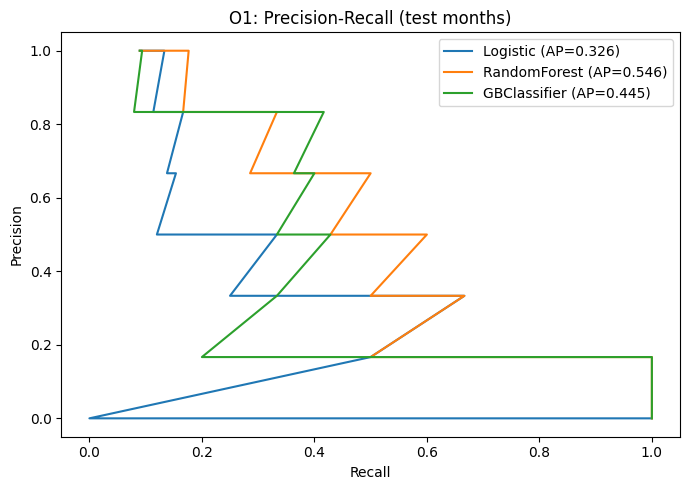

In [8]:
# ==== 5. O1: PR curves (Figure 53) ====
models = {
    "Logistic": LogisticRegression(max_iter=2000, solver="liblinear", class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=400, random_state=42, class_weight="balanced"),
    "GBClassifier": GradientBoostingClassifier(random_state=42),
}

pr_curves, aps = {}, {}
for name, clf in models.items():
    clf.fit(X_train, y_train_cls)
    if hasattr(clf, "predict_proba"):
        prob = clf.predict_proba(X_test)[:,1]
    else:
        prob = clf.decision_function(X_test)
    rec, prec, _ = precision_recall_curve(y_test_cls, prob)
    ap = average_precision_score(y_test_cls, prob)
    pr_curves[name] = (rec, prec)
    aps[name] = ap

fig, ax = plt.subplots(figsize=(7,5))
for name, (rec, prec) in pr_curves.items():
    ax.plot(rec, prec, label=f"{name} (AP={aps[name]:.3f})")
ax.set_title("O1: Precision-Recall (test months)")
ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
ax.legend()
fig.tight_layout()
out = os.path.join(FIG_DIR, "fig53_precision_recall.png")
fig.savefig(out, dpi=150, bbox_inches="tight"); print("Saved:", out)
plt.show()

Saved: /content/drive/MyDrive/Infosys 722/figs/fig54_recall_at_k.png


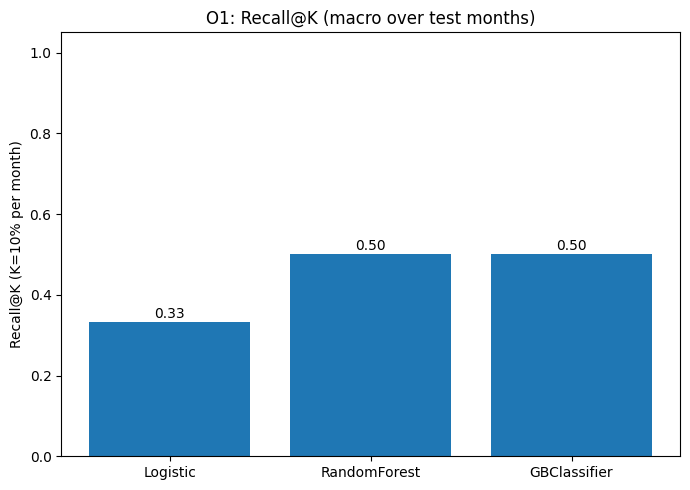

In [9]:
# ==== 6. O1: Recall@K per month (Figure 54) ====
def recall_at_k_per_month(df_slice, probs, labels, k_frac=0.10):
    vals = []
    for (y,m), g in df_slice.groupby(["Year","Month"]):
        idx = g.index.values
        k = max(1, int(round(k_frac * g["District"].nunique())))
        order = np.argsort(-probs[idx])
        top_idx = idx[order[:k]]
        tp = labels[top_idx].sum()
        total_pos = labels[idx].sum()
        vals.append((tp / total_pos) if total_pos > 0 else np.nan)
    vals = [v for v in vals if not np.isnan(v)]
    return float(np.mean(vals)) if vals else np.nan

recall_k = {}
for name, clf in models.items():
    if hasattr(clf, "predict_proba"):
        p = clf.predict_proba(X_test)[:,1]
    else:
        p = clf.decision_function(X_test)
    p_full = np.zeros(len(df)); p_full[X_test.index] = p
    recall_k[name] = recall_at_k_per_month(df.loc[test_mask], p_full, df["hotspot_next"].values, 0.10)

fig, ax = plt.subplots(figsize=(7,5))
ax.bar(list(recall_k.keys()), list(recall_k.values()))
for i, v in enumerate(recall_k.values()):
    ax.text(i, v + 0.01, f"{v:.2f}", ha="center")
ax.set_ylim(0,1.05)
ax.set_ylabel("Recall@K (K=10% per month)")
ax.set_title("O1: Recall@K (macro over test months)")
fig.tight_layout()
out = os.path.join(FIG_DIR, "fig54_recall_at_k.png")
fig.savefig(out, dpi=150, bbox_inches="tight"); print("Saved:", out)
plt.show()

Saved: /content/drive/MyDrive/Infosys 722/figs/fig55_rf_feature_importance.png


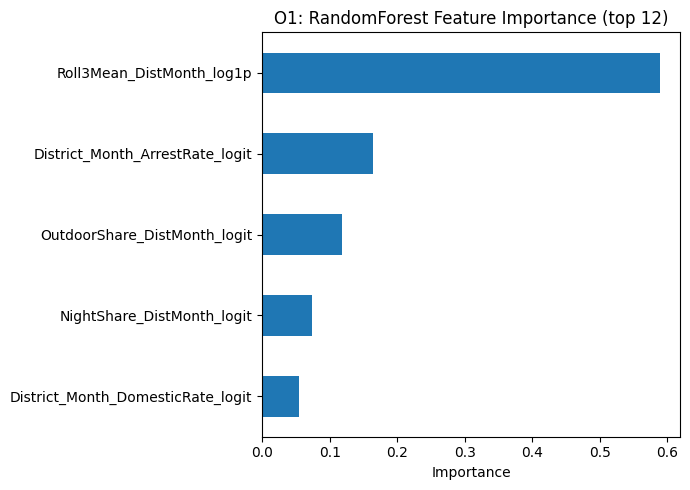

Saved: /content/drive/MyDrive/Infosys 722/figs/fig56_gb_feature_importance.png


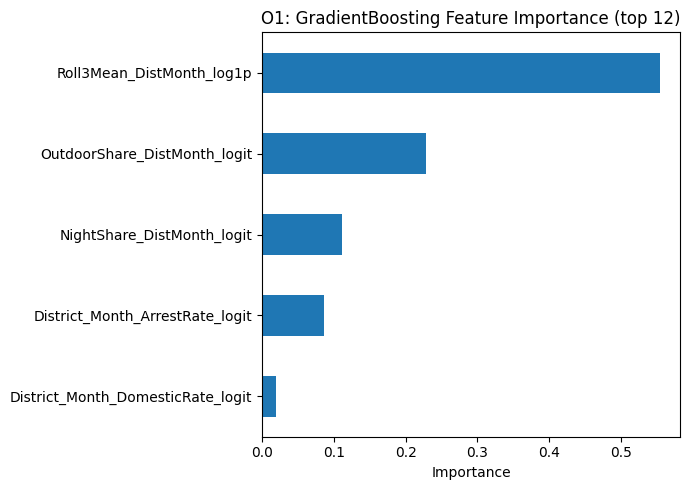

In [10]:
# ==== 7. O1: Feature importance (Figures 55–56) ====
def plot_feature_importance(model, X_cols, title, out_name, topn=12):
    if hasattr(model, "feature_importances_"):
        s = pd.Series(model.feature_importances_, index=X_cols).sort_values(ascending=False).head(topn)
    elif hasattr(model, "coef_"):
        s = pd.Series(np.abs(np.ravel(model.coef_)), index=X_cols).sort_values(ascending=False).head(topn)
    else:
        warnings.warn("Model does not expose importances; skipping.")
        return
    fig, ax = plt.subplots(figsize=(7,5))
    s.iloc[::-1].plot.barh(ax=ax)
    ax.set_title(title); ax.set_xlabel("Importance")
    fig.tight_layout()
    path = os.path.join(FIG_DIR, out_name)
    fig.savefig(path, dpi=150, bbox_inches="tight"); print("Saved:", path)
    plt.show()

plot_feature_importance(models["RandomForest"], X_train.columns, "O1: RandomForest Feature Importance (top 12)", "fig55_rf_feature_importance.png")
plot_feature_importance(models["GBClassifier"], X_train.columns, "O1: GradientBoosting Feature Importance (top 12)", "fig56_gb_feature_importance.png")

/tmp/ipython-input-3004995565.py:124: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preds[k] = preds[k].fillna(method="ffill").fillna(method="bfill")


MAE: {'Naive_Last': 66.23, 'Naive_Roll3': 87.61, 'Ridge': 71.58, 'RFReg': 79.62, 'GBReg': 84.19}
Saved: /content/drive/MyDrive/Infosys 722/figs/fig57_mae_models_vs_naive.png


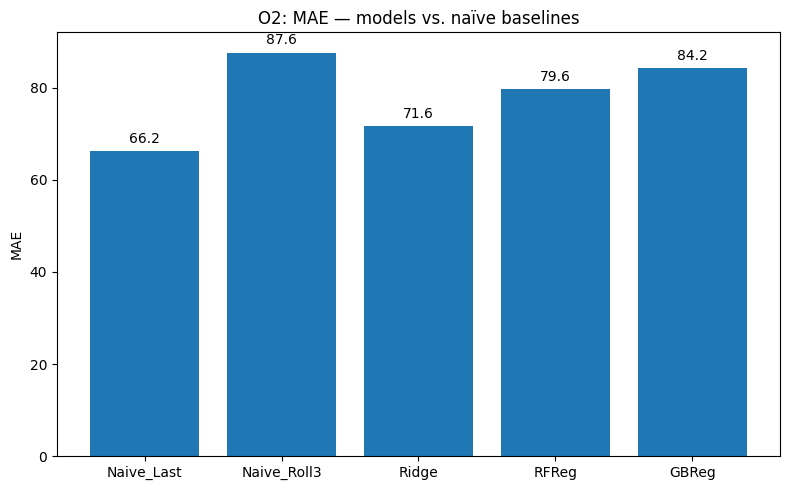

In [12]:
# ==== 8. O2: Regression vs naïve baselines (Figure 57) ====
# Build robust train/test for regression, generate naive baselines (no deprecation), fit models, plot MAE.

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

# ---------- 0) Assumptions & helpers ----------
FIG_DIR = "/content/drive/MyDrive/Infosys 722/figs"
os.makedirs(FIG_DIR, exist_ok=True)

# Prefer raw-count target if available; otherwise use log1p target and invert
if "y_count_next" in df.columns:
    target_is_log = False
    target_col = "y_count_next"
elif "y_count_next_log1p" in df.columns:
    target_is_log = True
    target_col = "y_count_next_log1p"
else:
    raise ValueError("Neither 'y_count_next' nor 'y_count_next_log1p' found in df.")

# Feature candidates (存在就用；不存在自动跳过)
cand_feats = [
    "Roll3Mean_DistMonth",            # raw
    "Roll3Mean_DistMonth_log1p",      # transformed
    "District_Month_DomesticRate_logit",
    "District_Month_ArrestRate_logit",
    "NightShare_DistMonth_logit",
    "OutdoorShare_DistMonth_logit",
    "Total",                          # raw
]
feat_cols = [c for c in cand_feats if c in df.columns]
if not feat_cols:
    raise ValueError("No regression features found. Please ensure Section 4.2 created the transformed columns.")

# For convenience: if using raw target but you only have transformed Roll3 mean etc., it's still fine.

# ---------- 1) Define train/test split (use existing mask if present; else default 2017-10..12 as test) ----------
if "train_mask" in locals() and "test_mask" in locals():
    mask_train = train_mask.copy()
    mask_test  = test_mask.copy()
else:
    # Expect Year/Month columns now exist (you set Year=2017 earlier)
    if "Year" not in df.columns:
        df["Year"] = 2017
    if "Month" not in df.columns:
        raise ValueError("Column 'Month' is required to create a temporal split.")
    # Default: last 3 months as test
    mask_test  = (df["Year"] == df["Year"].max()) & (df["Month"].isin([10, 11, 12]))
    mask_train = ~mask_test

# ---------- 2) Keep only rows with a valid regression target (drop NaN target) ----------
df_sorted = df.sort_values(["Year", "Month", "District"]).reset_index(drop=True)
df_reg = df_sorted[df_sorted[target_col].notna()].copy()

# Compute a consistent evaluation target in RAW COUNT space for MAE
if target_is_log:
    y_all = np.expm1(df_reg[target_col].astype(float))  # inverse log1p
else:
    y_all = df_reg[target_col].astype(float)

# Align masks to df_reg after filtering
reg_index = df_reg.index
mask_train_reg = mask_train.loc[reg_index] if isinstance(mask_train, pd.Series) else mask_train
mask_test_reg  = mask_test.loc[reg_index] if isinstance(mask_test, pd.Series) else mask_test

# ---------- 3) Naïve baselines (computed WITHOUT groupby.apply) ----------
# "Naive_Last": predict next month as THIS month's Total (per-district persistence)
if "Total" not in df_reg.columns:
    raise ValueError("Column 'Total' is required to build naive baselines.")
naive_last_all = df_reg["Total"].astype(float)

# "Naive_Roll3": predict next month as a 3-month rolling mean of THIS and previous months
naive_roll3_all = (
    df_reg
    .sort_values(["District", "Year", "Month"])
    .groupby("District")["Total"]
    .rolling(3, min_periods=1).mean()
    .reset_index(level=0, drop=True)
    .reindex(df_reg.index)
    .astype(float)
)

# ---------- 4) Prepare features X (fill NaN safely), targets y ----------
X_all = df_reg[feat_cols].astype(float).copy()
# Where raw 'Roll3Mean_DistMonth' is missing but log1p version is present, we can back-transform for completeness (optional)
if "Roll3Mean_DistMonth" not in X_all.columns and "Roll3Mean_DistMonth_log1p" in df_reg.columns:
    X_all["Roll3Mean_DistMonth"] = np.expm1(df_reg["Roll3Mean_DistMonth_log1p"])
X_all = X_all.fillna(0.0)

X_train = X_all[mask_train_reg]
X_test  = X_all[mask_test_reg]
y_train_reg = y_all[mask_train_reg]
y_test_reg  = y_all[mask_test_reg]

# Sanity checks: no NaN in targets
if np.isnan(y_train_reg).any() or np.isnan(y_test_reg).any():
    raise ValueError("y_train_reg or y_test_reg still contains NaN after filtering. Check your target construction.")

# ---------- 5) Fit models ----------
rfreg  = RandomForestRegressor(n_estimators=400, random_state=42)
gbreg  = GradientBoostingRegressor(random_state=42)
ridge  = Ridge(alpha=1.0)

rfreg.fit(X_train, y_train_reg)
gbreg.fit(X_train, y_train_reg)
ridge.fit(X_train, y_train_reg)

# ---------- 6) Predictions on TEST rows ----------
preds = {
    "Naive_Last": naive_last_all[mask_test_reg],
    "Naive_Roll3": naive_roll3_all[mask_test_reg],
    "Ridge": pd.Series(ridge.predict(X_test), index=X_test.index),
    "RFReg": pd.Series(rfreg.predict(X_test), index=X_test.index),
    "GBReg": pd.Series(gbreg.predict(X_test), index=X_test.index),
}

# Fill any tiny gaps in naive series (should be rare after our construction)
for k in ["Naive_Last", "Naive_Roll3"]:
    preds[k] = preds[k].fillna(method="ffill").fillna(method="bfill")

# ---------- 7) MAE in RAW COUNT space ----------
mae_scores = {k: mean_absolute_error(y_test_reg, v) for k, v in preds.items()}
print("MAE:", {k: round(v, 2) for k, v in mae_scores.items()})

# ---------- 8) Plot Figure 57 ----------
fig, ax = plt.subplots(figsize=(8, 5))
labels = list(mae_scores.keys()); vals = [mae_scores[k] for k in labels]
ax.bar(labels, vals)
for i, v in enumerate(vals):
    ax.text(i, v + max(0.02 * max(vals), 1.0), f"{v:.1f}", ha="center")
ax.set_ylabel("MAE")
ax.set_title("O2: MAE — models vs. naïve baselines")
fig.tight_layout()
out = os.path.join(FIG_DIR, "fig57_mae_models_vs_naive.png")
fig.savefig(out, dpi=150, bbox_inches="tight"); print("Saved:", out)
plt.show()
